In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.io import export_svgs
import bokeh as bk
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#datos = pd.read_csv("./drive/My Drive/Colab Notebooks/data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [3]:
#obj_rg = open("./drive/My Drive/Colab Notebooks/data/reference_genes.txt")
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

In [6]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [7]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [8]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

In [9]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.15))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [10]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [11]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [12]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [13]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    kl_d = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        y_proba = D.predict_proba(X_comb)
        #kl_d.append(np.mean((1-y_proba)/y_proba))
        kl_d.append(np.mean(y_proba*np.log(y_proba/(1-y_proba))))
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall, kl_d

In [14]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 9)                 11559     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


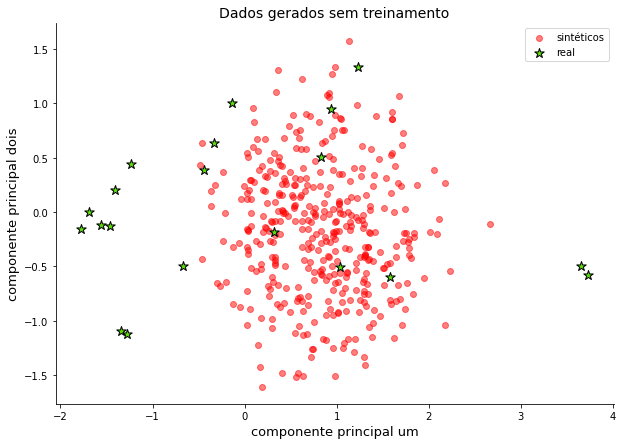

In [0]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
g_loss, d_loss, precision, recall, kld = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
epoch:[1/1700] [Discriminator::d_loss: 0.743062],[Generator::loss: 0.666070], 1.022740[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.729001],[Generator::loss: 0.689769], 0.265762[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.734806],[Generator::loss: 0.681545], 0.148529[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.759997],[Generator::loss: 0.692694], 0.136592[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.749624],[Generator::loss: 0.676840], 0.121271[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.720705],[Generator::loss: 0.709272], 0.122151[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.742224],

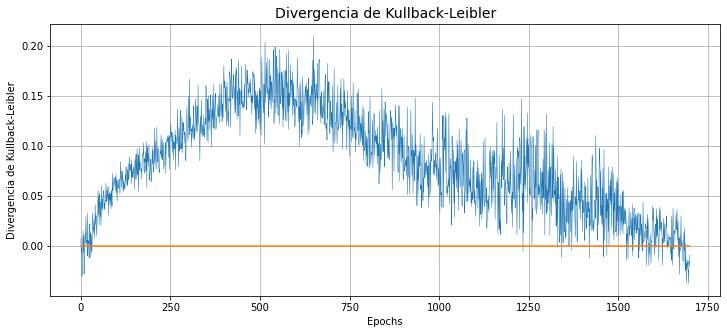

In [0]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(kld)), kld, linewidth=.5)
plt.plot(range(len(kld)), np.zeros(len(kld)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

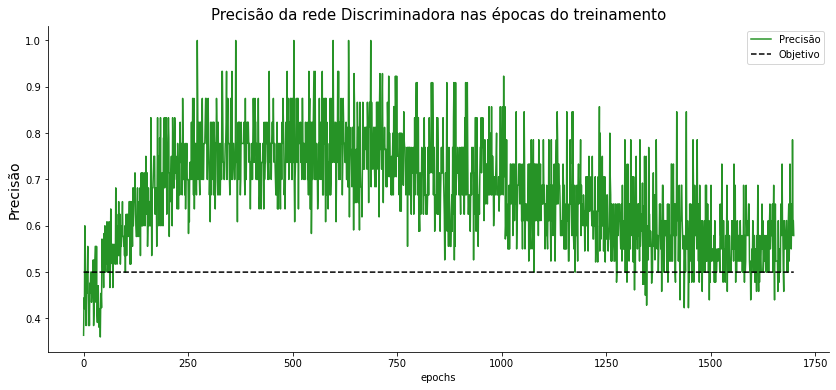

In [0]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

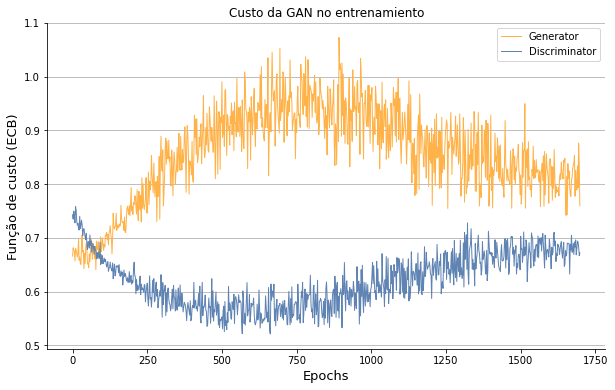

In [0]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 2)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.title("Custo da GAN no entrenamiento")
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248", linewidth=1)
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4", linewidth=1)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Função de custo (ECB)", fontsize=13)
plt.grid(axis="y")
plt.legend();

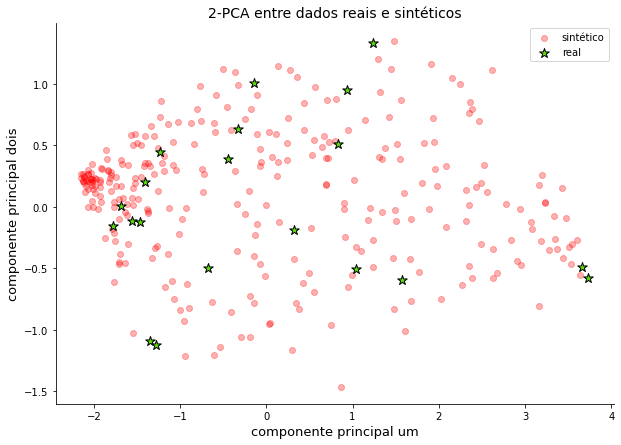

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
min_pre = np.inf
dict_weights = {}
l_dist = []
for i in range(100):
    t_i = time()
    G = obj_G.compileG()
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(30):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        #y_proba = D.predict_proba(X_gen)
        y_predict = D.predict_classes(X_gen)
        d = []
        for g in range(X_train.shape[0]):
            #print(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
            #print(abs(1-np.mean((1-y_proba)/y_proba)))
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d))+ abs(0.5 - np.mean(y_predict)))

    w_f = gan.get_weights().copy()
    l_dist.append(np.mean(np.array(l_pre)))
    dict_weights[np.mean(np.array(l_pre))] = [i, l_dist[-1], w_f]
    if l_dist[-1] < min_pre:
        min_pre = l_dist[-1]
        w_best = w_f
    t_f = time()
    print("iteração[",i,"] : erro:",l_dist[i],"tempo:", np.round(t_f-t_i,4), "[s]")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
iteração[ 0 ] : erro: 0.9063484896346964 tempo: 198.161 [s]
iteração[ 1 ] : erro: 1.035125284086244 tempo: 202.4993 [s]
iteração[ 2 ] : erro: 0.8085457767552231 tempo: 203.1351 [s]
iteração[ 3 ] : erro: 0.8818297242657106 tempo: 202.8032 [s]
iteração[ 4 ] : erro: 0.8188971081847265 tempo: 208.6005 [s]
iteração[ 5 ] : erro: 0.8167858394499122 tempo: 213.0408 [s]
iteração[ 6 ] : erro: 0.9456828486764717 tempo: 209.8611 [s]
iteração[ 7 ] : erro: 0.8117919935756175 tempo: 208.4451 [s]
iteração[ 8 ] : erro: 0.7750159500487882 tempo: 208.8164 [s]
iteração[ 9 ] : erro: 0.7785488805682073 tempo: 215.74

In [0]:
np.save("./drive/My Drive/Colab Notebooks/data/dictionary_weights", dict_weights)

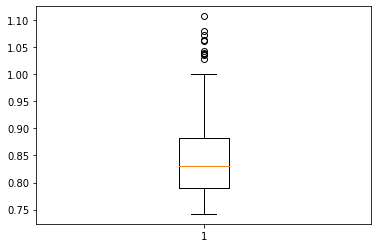

In [0]:
plt.boxplot(l_dist);

In [0]:
dict_weights[0.7723649766331931]

[0, [array([[-0.0355559 ,  0.02731352,  0.02486728, ...,  0.17094366,
          -0.21465062, -0.19510424],
         [ 0.19870575, -0.19854163,  0.00268583, ..., -0.20457327,
           0.09547026, -0.1790467 ],
         [ 0.24036534,  0.16082735,  0.24055083, ...,  0.19479771,
          -0.15399212, -0.21110648],
         ...,
         [-0.20341508,  0.10222159, -0.01730911, ..., -0.17522171,
          -0.20599656,  0.02298634],
         [ 0.20842777,  0.23642649, -0.20786823, ...,  0.02198412,
          -0.19477499, -0.01467268],
         [ 0.13880949, -0.22207598,  0.17832424, ...,  0.03953595,
           0.18898539,  0.14337201]], dtype=float32),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  array([[ 0.09426019,  0.02184075, -0.09427793, ...,  0.06149998,
           0.01516236, 

## Results and plots

In [0]:
weights = np.load("./drive/My Drive/Colab Notebooks/data/dictionary_weights.npy", allow_pickle=True).item()

In [0]:
type(weights)

dict

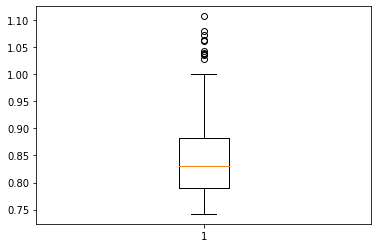

In [0]:
similarity = []
for key in weights.keys():
    similarity.append(weights[key][1])

similarity = np.array(similarity)
plt.boxplot(similarity);

In [15]:
def boxplot_params(x):
    """
    This function retunrs necessary parameters to plot
    a boxplot with bokeh
    """
    q25 = np.quantile(x, .25, interpolation="midpoint")
    q50 = np.quantile(x, .5, interpolation="midpoint")
    q75 = np.quantile(x, .75, interpolation="midpoint")
    IQR = q75 - q25
    lower = q25 - 1.5*IQR
    upper = q75 + 1.5*IQR
    outliers = x[[x<lower]and[x>upper]]

    return lower, q25, q50, q75, upper, outliers

In [16]:
similarity = np.load("./data/similarity.npy", allow_pickle=True)
lower, q25, q50, q75, upper, outliers = boxplot_params(similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


In [71]:
p = figure(tools="", toolbar_location=None, width=220, height= 250, x_range=[0,2])

p.segment(1, lower, 1, q25, line_color="black")
p.segment(1, upper, 1, q75, line_color="black")
p.rect(1, lower, width=.3, height=.0005, line_color="black")
p.rect(1, upper, width=.3, height=.0005, line_color="black")
p.vbar(1, 0.7, q75, q50, fill_color="#E08E79", line_color="black")
p.vbar(1, 0.7, q50, q25, fill_color="#3B8686", line_color="black")
p.circle(1, outliers, size=7, color="#F38630", fill_alpha=0.6, legend_label="Piores pesos")
#best_case
p.circle(1, min(similarity), size=7, color="green", fill_alpha=0.6, legend_label="Melhor peso")
p.xgrid.grid_line_color = None
p.yaxis.axis_label= "Similaridade (S)"
#p.xaxis.visible = False
p.xaxis.ticker = [1]
p.yaxis.ticker = [np.round(lower,2), np.round(q25,2), np.round(q50, 2), np.round(q75,2), np.round(upper,2)]
#p.yaxis.bounds = (np.round(lower,2), np.round(upper,2))
#p.xaxis.axis_line_color = "red"
p.output_backend = "svg"
export_svgs(p, "./images/boxplot_similarity.svg")
show(p)

In [70]:
p = figure(tools="", toolbar_location=None, width=280, height= 200, y_range=[0,2])

p.segment(lower, 1, q25, 1, line_color="black")
p.segment(upper, 1, q75, 1, line_color="black")
p.rect(lower, 1, width=.0005, height=.3, line_color="black")
p.rect(upper, 1, width=.0005, height=.3, line_color="black")
p.hbar(1, 0.7, q75, q50, fill_color="#E08E79", line_color="black")
p.hbar(1, 0.7, q50, q25, fill_color="#3B8686", line_color="black")
p.circle(outliers, 1, size=7, color="#F38630", fill_alpha=0.6, legend_label="Piores pesos")
#best_case
p.circle(min(similarity),1, size=7, color="green", fill_alpha=0.6, legend_label="Melhor peso")
p.ygrid.grid_line_color = None
p.xaxis.axis_label= "Similaridade (S)"
#p.xaxis.visible = False
p.yaxis.ticker = [1]
#p.xaxis.ticker = [np.round(lower,2), np.round(q25,2), np.round(q50, 2), np.round(q75,2), np.round(upper,2)]
p.output_backend = "svg"
#export_svgs(p, "./images/boxplot_similarity.svg")
show(p)